In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [2]:
!rm -rf /kaggle/working/*

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split


random_seed = 42
random.seed(random_seed)


source_folder = '/kaggle/input/microscopic-peripheral-blood-cell-images/PBC_dataset_normal_DIB'
destination_folder = 'data'
train_ratio = 0.01 
test_size = 4000   

os.makedirs(os.path.join(destination_folder, 'train'), exist_ok=True)
os.makedirs(os.path.join(destination_folder, 'val'), exist_ok=True)
os.makedirs(os.path.join(destination_folder, 'test'), exist_ok=True)

total_images = []
class_images = {}

for class_name in os.listdir(source_folder):
    class_folder = os.path.join(source_folder, class_name)
    
    if os.path.isdir(class_folder):
        images = os.listdir(class_folder)
        total_images.extend([(class_name, img) for img in images])
        class_images[class_name] = images

random.shuffle(total_images)

train_count = max(1, int(len(total_images) * train_ratio))
train_images = total_images[:train_count]
remaining_images = total_images[train_count:]

test_images = remaining_images[:test_size]
val_images = remaining_images[test_size:]

train_class_images = {class_name: [] for class_name in class_images.keys()}
test_class_images = {class_name: [] for class_name in class_images.keys()}
val_class_images = {class_name: [] for class_name in class_images.keys()}

for class_name, img in train_images:
    train_class_images[class_name].append(img)

for class_name, img in test_images:
    test_class_images[class_name].append(img)

for class_name, img in val_images:
    val_class_images[class_name].append(img)

for class_name, images in train_class_images.items():
    class_folder = os.path.join(source_folder, class_name)
    train_dest = os.path.join(destination_folder, 'train', class_name)
    os.makedirs(train_dest, exist_ok=True)
    for img in images:
        shutil.copy(os.path.join(class_folder, img), os.path.join(train_dest, img))

for class_name, images in val_class_images.items():
    class_folder = os.path.join(source_folder, class_name)
    val_dest = os.path.join(destination_folder, 'val', class_name)
    os.makedirs(val_dest, exist_ok=True)
    for img in images:
        shutil.copy(os.path.join(class_folder, img), os.path.join(val_dest, img))

for class_name, images in test_class_images.items():
    class_folder = os.path.join(source_folder, class_name)
    test_dest = os.path.join(destination_folder, 'test', class_name)
    os.makedirs(test_dest, exist_ok=True)
    for img in images:
        shutil.copy(os.path.join(class_folder, img), os.path.join(test_dest, img))

print("Data successfully split into train (1%), val, and test (4000 images) folders with seed", random_seed)

Data successfully split into train (1%), val, and test (4000 images) folders with seed 42


In [4]:
import os

def filter_invalid_files(directory):
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.startswith('.'):
                print(f"Removing invalid file: {file}")
                os.remove(os.path.join(subdir, file))

filter_invalid_files('/kaggle/working/data/train')
filter_invalid_files('/kaggle/working/data/test')
filter_invalid_files('/kaggle/working/data/val')


Removing invalid file: .DS_169665.jpg


In [5]:
train_dir = '/kaggle/working/data/train'
val_dir = '/kaggle/working/data/val'
test_dir = '/kaggle/working/data/test'

# Image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Loading the data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 170 images belonging to 8 classes.
Found 12922 images belonging to 8 classes.
Found 4000 images belonging to 8 classes.


In [6]:

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)


for layer in base_model.layers:
    layer.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
def lr_scheduler(epoch, lr):
    max_lr = 1e-3
    if epoch < 10:
        return lr + (max_lr - lr) / 10
    else:
        return max_lr * (1 - (epoch - 10) / 20)
lr_callback = LearningRateScheduler(lr_scheduler)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[lr_callback, checkpoint]
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726247149.837550      91 service.cc:145] XLA service 0x7ccd4c003750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726247149.837601      91 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726247149.837607      91 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.1875 - loss: 2.2090 

I0000 00:00:1726247156.834787      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 ━━━━━━━━━━━━━━━━━━━━ 57s 8s/step - accuracy: 0.1777 - loss: 2.3287 - val_accuracy: 0.1820 - val_loss: 2.6815 - learning_rate: 0.0010
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - accuracy: 0.1967 - loss: 2.5140 - val_accuracy: 0.1679 - val_loss: 2.2991 - learning_rate: 0.0010
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - accuracy: 0.1334 - loss: 2.2631 - val_accuracy: 0.1820 - val_loss: 2.1929 - learning_rate: 0.0010
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - accuracy: 0.2239 - loss: 2.0322 - val_accuracy: 0.1679 - val_loss: 2.2018 - learning_rate: 0.0010
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - accuracy: 0.1974 - loss: 2.0715 - val_accuracy: 0.1963 - val_loss: 2.0396 - learning_rate: 0.0010
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - accuracy: 0.1941 - loss: 1.9847 - val_accuracy: 0.1679 - val_loss: 2.1128 - learning_rate: 0.0010
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.1729 - loss: 2.0662 - val_accuracy: 0.1963 - val_loss: 1.9995

In [8]:
# Load the best model
model.load_weights('best_model.keras')

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.2249 - loss: 1.9523
Test Accuracy: 22.98%


# Hybrid Approach

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [10]:

train_dir = '/kaggle/working/data/train'
val_dir = '/kaggle/working/data/val'
test_dir = '/kaggle/working/data/test'

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_directory(train_dir, target_size=(224, 224),
                                              batch_size=32, class_mode='categorical', shuffle=False)

val_generator = datagen.flow_from_directory(val_dir, target_size=(224, 224),
                                            batch_size=32, class_mode='categorical', shuffle=False)

test_generator = datagen.flow_from_directory(test_dir, target_size=(224, 224),
                                             batch_size=32, class_mode='categorical', shuffle=False)



Found 170 images belonging to 8 classes.
Found 12922 images belonging to 8 classes.
Found 4000 images belonging to 8 classes.


In [11]:

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# x = base_model.output
# x = GlobalAveragePooling2D()(x)  # Reduces dimensions from (7, 7, 2048) to (2048)
# base_model = Model(inputs=base_model.input, outputs=x)
# # Extract features from the training, validation, and test datasets


def extract_features(generator, base_model):
    features = base_model.predict(generator)
    labels = generator.classes
    return features, labels

train_features, train_labels = extract_features(train_generator, base_model)
val_features, val_labels = extract_features(val_generator, base_model)
test_features, test_labels = extract_features(test_generator, base_model)

train_features = train_features.reshape(train_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 687ms/step
404/404 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step


In [12]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
X_train, X_val, y_train, y_val = train_features, val_features, train_labels, val_labels

knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=42)
svm = SVC()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

param_grid_knn = {'n_neighbors': [3, 5, 7]}
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
param_grid_xgb = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}

grid_knn = GridSearchCV(knn, param_grid_knn, cv=5)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5)
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5)


In [14]:
X_train.shape

(170, 100352)

In [15]:
grid_knn.fit(X_train, y_train)
grid_svm.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)
# grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20], 'n_estimators': [100, 200]})

In [16]:
# Evaluate on validation set
knn_val_pred = grid_knn.predict(X_val)
rf_val_pred = grid_rf.predict(X_val)
svm_val_pred = grid_svm.predict(X_val)
# xgb_val_pred = grid_xgb.predict(X_val)

In [17]:
# Accuracy on validation data
acc_knn = accuracy_score(y_val, knn_val_pred)
acc_rf = accuracy_score(y_val, rf_val_pred)
acc_svm = accuracy_score(y_val, svm_val_pred)
# acc_rf = accuracy_score(y_val, xgb_val_pred)
print("KNN Validation Accuracy:", acc_rf)
print("Random Forest Validation Accuracy:", acc_knn)
print("SVM Validation Accuracy:", acc_svm)
# print("XGBoost Validation Accuracy:", acc_rf)



KNN Validation Accuracy: 0.6553939018727751
Random Forest Validation Accuracy: 0.5643863179074446
SVM Validation Accuracy: 0.7614920290976629


In [18]:
best_model = grid_svm.best_estimator_ 
test_pred = best_model.predict(test_features)
print("Test Accuracy with RF:", accuracy_score(test_labels, test_pred))

Test Accuracy with RF: 0.7625


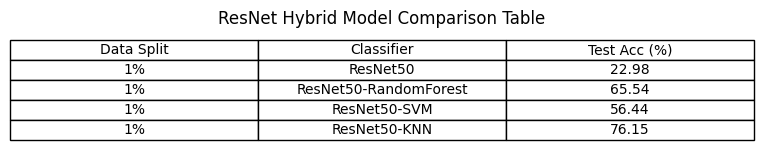

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Data Split': ['1%', '1%', '1%', '1%'],
    'Classifier': ['ResNet50', 'ResNet50-RandomForest', 'ResNet50-SVM', 'ResNet50-KNN'],
    'Test Acc (%)': [f'{round(test_acc*100, 2)}',f'{round(acc_rf*100, 2)}',f'{round(acc_knn*100, 2)}',f'{round(acc_svm*100, 2)}'],
}

df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(8, 1))
ax.axis('tight')
ax.axis('off')
tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2) 
plt.title('ResNet Hybrid Model Comparison Table', pad=20)
plt.show()

In [20]:
resnet50_model_size = base_model.count_params()
print(f"ResNet50 Model Size: {resnet50_model_size} parameters")

ResNet50 Model Size: 23587712 parameters
